In [64]:
import os
# import pandas as pd 
import polars as pl
# import scanpy as sc
import numpy as np
import typing as tp
import re
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import umap as umap
# import hdbscan as hdb

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

'/scratch2-shared/david/colopaint3D/python'

In [65]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./data/2_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './data/1_FeaturesImages_meanstd_PerPlate'


In [66]:
filenames = ['HCT116_MedianAgg_meanstd']
# filenames = ['HCT116_MeanAgg_medianmad']
# filenames = ['HT29_MeanAgg_medianmad']
# filenames = ['HT29_MedianAgg_meanstd']
# statmet = 'SingleSlice'
# statmet = 'prototype'
statmet = 'WellAggregates'
# statmet = 'SingleCell'
# filenames = ['HCT116_MedianAgg_meanstd_prototype_slice_selected']
# filenames = ['HT29_mad']
# filenames = ['HT29_mean']
# filenames = ['HCT116_mad']
# filenames = ['HCT116_mean']
# filenames = ['HCT116_Slice3MeanAgg_medianmad']
# filenames = ['HCT116_Slice3MedianAgg_meanstd']
# filenames = ['HT29_Slice3MeanAgg_medianmad']
# filenames = ['HT29_Slice3MedianAgg_meanstd']
statmets = ['SingleCell', 'Aggregates']

dropcols = ['Nuclei_Location_Center_X',
            'Nuclei_Location_Center_Y',
            'Location',
            'ImageNumber_',
            'Parent',
            'Children',
            '_ObjectNumber',
            '_Object_Number',
            '_Y',
            '_X' 
            ]


cons = ['pos_con', 'neg_con']
nodmso = ['trt']
wdmso = ['pos_con']
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]

##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]

In [67]:
def readData(filename, statmet='SingleCell'):
    df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filename}.parquet')
    ##This here is important!!!!!!
    # df=df.select([c for c in df.columns if not is_meta_column(c)])
    # dataNpy = df.to_numpy(df.select(float_columns))
    ##
    onehot_list = df.select(['Metadata_cmpd_pathway'])['Metadata_cmpd_pathway'].unique().to_list()
    onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
    df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))
    return df

# this is code from Dan
def is_meta_column(
    c:str,
    allowlist:tp.List[str]=["Metadata_Well","Metadata_Barcode","Metadata_AcqID","Metadata_Site"],
    denylist:tp.List[str]=[],
)->bool:
    """
        allowlist:
            the function will return False for these, no matter if they are metadata or not
        denylist:
            the function will return True for these, no matter if they are metadata or not
    """
    if c in allowlist:
        return False
    if c in denylist:
        return True
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        Location
        _[XYZ]_
        _[XYZ]$
        BoundingBox
        Phase
        Orientation
        Angle
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        MD5Digest
        RadialDistribution_Frac
        Intensity_
        _Manders
        _Overflow
    '''.split():
        if re.search(ex, c):
            return True
    return False


def oneHot(row, mapping):
    return mapping.get(row, -1)

def makePCA(df, name='', statmet='SingleCell' , n_components=2):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    pca_model = PCA(n_components=2)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    df = df.with_columns([
    pl.Series('pc1', pcaOut[:, 0]),  
    pl.Series('pc2', pcaOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['pc1'].to_list(),
                    y=df['pc2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'PCA {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()
    return df

def makeUMAP(df, name='', statmet='SingleCell' , nn = 200, is_supervised=True, n_components=100, min_dist=0.1, spread= 5, n_epochs=None, metric='cosine', use_pca=True):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        , n_jobs=-1
                        )
    if use_pca:
        pca_model = PCA(n_components=n_components)
        pca_model = pca_model.fit(dataN)
        dataN = pca_model.transform(dataN)
        
    if is_supervised:
        umapOut = umap_model.fit_transform(dataN, y=df['Metadata_cmpd_onehot'].to_list())
        isSup = 'Supervised'
    else:
        umapOut = umap_model.fit_transform(dataN)
        isSup = 'Unsupervised'
    df = df.with_columns([
    pl.Series('umap1', umapOut[:, 0]),  
    pl.Series('umap2', umapOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['umap1'].to_list(),
                    y=df['umap2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'umap {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}'):
    #     os.makedirs(f'{OutputDir}/{statmet}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return df


In [68]:
df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filenames[0]}.parquet')

In [69]:
df.head()

Metadata_Barcode,Metadata_Well,Cells_RadialDistribution_ZernikeMagnitude_CONC_7_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_6_4,Nuclei_RadialDistribution_ZernikePhase_PHAandWGA_6_0,Cytoplasm_AreaShape_MedianRadius,Cells_AreaShape_Zernike_3_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_9_5,Cells_RadialDistribution_ZernikePhase_MITO_3_1,Cells_Granularity_15_CONC,Nuclei_RadialDistribution_ZernikePhase_HOECHST_9_3,Cells_AreaShape_MaxFeretDiameter,Cytoplasm_Correlation_RWC_HOECHST_PHAandWGA,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_RadialDistribution_ZernikeMagnitude_CONC_5_1,Cells_Correlation_K_MITO_PHAandWGA,Nuclei_RadialDistribution_RadialCV_MITO_1of4,Cytoplasm_RadialDistribution_ZernikePhase_CONC_5_3,Cells_RadialDistribution_ZernikeMagnitude_HOECHST_7_3,Cells_Correlation_Costes_HOECHST_MITO,Nuclei_RadialDistribution_ZernikeMagnitude_PHAandWGA_3_1,Cells_RadialDistribution_ZernikeMagnitude_CONC_6_6,Nuclei_Location_CenterMassIntensity_X_PHAandWGA,Cytoplasm_RadialDistribution_RadialCV_PHAandWGA_3of4,Cytoplasm_RadialDistribution_ZernikePhase_CONC_5_5,Cytoplasm_Correlation_RWC_PHAandWGA_HOECHST,Nuclei_RadialDistribution_ZernikePhase_SYTO_6_4,Nuclei_RadialDistribution_ZernikePhase_SYTO_4_2,Cytoplasm_AreaShape_Center_X,Cells_RadialDistribution_ZernikeMagnitude_MITO_8_8,Nuclei_Intensity_MaxIntensityEdge_SYTO,Cytoplasm_Intensity_MADIntensity_HOECHST,Cells_Intensity_MeanIntensity_MITO,Cytoplasm_Granularity_2_MITO,Nuclei_AreaShape_MajorAxisLength,Cells_Correlation_Manders_PHAandWGA_MITO,Cells_RadialDistribution_ZernikeMagnitude_SYTO_8_6,…,Cells_FileName_CONC,Nuclei_FileName_HOECHST,Nuclei_PathName_CONC,Metadata_cmpd_cp_id,Metadata_cmpd_barcode,Cytoplasm_ObjectNumber,Metadata_Site,Cytoplasm_PathName_MITO,Cytoplasm_FileName_MITO,Cytoplasm_AreaShape_ConvexArea,Nuclei_PathName_MITO,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Nuclei_FileName_CONC,Metadata_cmpd_pathway,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cells_Parent_cells,Cytoplasm_Location_Center_Z,Nuclei_FileName_SYTO,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_PathName_HOECHST,Cytoplasm_Number_Object_Number,Cytoplasm_PathName_CONC,Cytoplasm_AreaShape_BoundingBoxArea,Metadata_cmpd_pert_type,Cells_PathName_MITO,Cells_Number_Object_Number,Metadata_cmpd_plate_well,Metadata_cmpd_cell_line,Metadata_cmpd_cmpdname,Metadata_PlateWell,Cytoplasm_Metadata_AcqID,Metadata_cmpd_target,Cytoplasm_AreaShape_EulerNumber,Nuclei_FileName_MITO,Cytoplasm_PathName_PHAandWGA,Cytoplasm_PathName_SYTO,Cells_PathName_HOECHST
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,str,str,str,i64,str,i32,i32,str,str,i32,str,i32,str,str,i32,i32,i32,str,i32,str,i32,str,i32,str,str,i32,str,str,str,str,i32,str,i32,str,str,str,str
"""PB000137""","""F04""",0.000616,0.000145,0.0,8.246211,0.031544,0.000076,0.316136,0.202784,-0.047231,72.135269,0.479671,414.0,0.001029,0.348488,0.018967,0.053378,0.000319,1.0,0.001223,0.000389,572.220459,0.0,0.14778,0.476146,0.21377,-0.110001,572.013672,0.002434,0.048631,0.000969,0.170262,0.146781,47.76746,1.0,0.000574,…,"""Well-F04-z0-CONC.ome.tiff""",null,null,5532,"""PB000137""",1,0,"""/share/mikro2/nikon/spher-colo…","""Well-F04-z0-MITO.ome.tiff""",2777,null,194,null,"""MAPK""",256,1,0,null,542,"""/share/mikro2/nikon/spher-colo…",1,"""/share/mikro2/nikon/spher-colo…",3534,"""trt""","""/share/mikro2/nikon/spher-colo…",1,"""PB000137_F04""","""HCT116""","""Doramapimod (BIRB 796)""","""PB000137_F04""",4185,"""p38 MAPK""",1,null,"""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…"
"""PB000137""","""B12""",0.000938,0.000212,0.0,8.108246,0.032205,0.000106,0.165444,0.0,-0.011328,71.227615,0.457127,427.0,0.001557,0.440248,0.022989,-0.14623,0.000414,1.0,0.001649,0.00055,455.379578,0.0,-0.248179,0.447279,0.073352,0.013056,455.054199,0.002831,0.073657,0.002422,0.197819,0.223604,48.69717,1.0,0.000858,…,"""Well-B12-z0-CONC.ome.tiff""",n

In [70]:
df.select(pl.col('Metadata_cmpd_pathway')).to_series().unique().to_list()

['Angiogenesis',
 'etop',
 'water',
 'Apoptosis',
 'sorb',
 'Cell Cycle',
 'TGF-beta/Smad',
 'Others',
 'dmso',
 'MAPK',
 'JAK/STAT',
 'PI3K/Akt/mTOR',
 'Epigenetics',
 'stau',
 'Proteases',
 'Cytoskeletal Signaling',
 'DNA Damage',
 'Protein Tyrosine Kinase',
 'Stem Cells & Wnt',
 'fenb']

In [71]:
df_nometa=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

In [72]:
df_nometa.head()

Cells_RadialDistribution_ZernikeMagnitude_CONC_7_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_6_4,Cytoplasm_AreaShape_MedianRadius,Cells_AreaShape_Zernike_3_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_9_5,Cells_Granularity_15_CONC,Cells_AreaShape_MaxFeretDiameter,Cytoplasm_Correlation_RWC_HOECHST_PHAandWGA,Cells_RadialDistribution_ZernikeMagnitude_CONC_5_1,Cells_Correlation_K_MITO_PHAandWGA,Nuclei_RadialDistribution_RadialCV_MITO_1of4,Cells_RadialDistribution_ZernikeMagnitude_HOECHST_7_3,Cells_Correlation_Costes_HOECHST_MITO,Nuclei_RadialDistribution_ZernikeMagnitude_PHAandWGA_3_1,Cells_RadialDistribution_ZernikeMagnitude_CONC_6_6,Cytoplasm_RadialDistribution_RadialCV_PHAandWGA_3of4,Cytoplasm_Correlation_RWC_PHAandWGA_HOECHST,Cells_RadialDistribution_ZernikeMagnitude_MITO_8_8,Cytoplasm_Granularity_2_MITO,Nuclei_AreaShape_MajorAxisLength,Cells_RadialDistribution_ZernikeMagnitude_SYTO_8_6,Nuclei_Granularity_14_HOECHST,Cells_AreaShape_EquivalentDiameter,Nuclei_AreaShape_Zernike_6_4,Cells_RadialDistribution_ZernikeMagnitude_HOECHST_7_7,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_3_1,Nuclei_Granularity_11_SYTO,Cells_Correlation_Overlap_HOECHST_PHAandWGA,Cells_RadialDistribution_MeanFrac_SYTO_4of4,Cytoplasm_RadialDistribution_MeanFrac_CONC_4of4,Cytoplasm_Neighbors_FirstClosestDistance_Adjacent,Cells_RadialDistribution_ZernikeMagnitude_PHAandWGA_5_1,Cells_RadialDistribution_ZernikeMagnitude_PHAandWGA_4_0,Nuclei_RadialDistribution_ZernikeMagnitude_SYTO_5_3,Cytoplasm_RadialDistribution_ZernikeMagnitude_HOECHST_4_2,Nuclei_Granularity_7_PHAandWGA,Cells_Granularity_2_SYTO,…,Cells_RadialDistribution_ZernikeMagnitude_SYTO_8_0,Cells_RadialDistribution_ZernikeMagnitude_MITO_6_4,Nuclei_Correlation_Correlation_CONC_HOECHST,Nuclei_Correlation_K_CONC_PHAandWGA,Cytoplasm_AreaShape_Zernike_4_0,Cytoplasm_Correlation_Costes_SYTO_MITO,Nuclei_AreaShape_Zernike_8_6,Nuclei_Correlation_K_PHAandWGA_CONC,Cytoplasm_RadialDistribution_ZernikeMagnitude_PHAandWGA_5_3,Cytoplasm_RadialDistribution_ZernikeMagnitude_CONC_2_2,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_RadialDistribution_ZernikeMagnitude_HOECHST_6_2,Cytoplasm_Granularity_15_CONC,Cytoplasm_Granularity_15_MITO,Cytoplasm_Granularity_4_HOECHST,Cells_Granularity_10_PHAandWGA,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_3_3,Cytoplasm_AreaShape_Zernike_8_0,Cytoplasm_Granularity_13_SYTO,Cytoplasm_Correlation_K_CONC_SYTO,Nuclei_AreaShape_Zernike_4_2,Cytoplasm_RadialDistribution_ZernikeMagnitude_HOECHST_5_1,Cells_RadialDistribution_RadialCV_HOECHST_2of4,Cells_RadialDistribution_ZernikeMagnitude_PHAandWGA_6_4,Cells_Correlation_RWC_PHAandWGA_MITO,Cells_AreaShape_Zernike_7_5,Cytoplasm_Correlation_Correlation_HOECHST_SYTO,Cytoplasm_Correlation_Costes_CONC_MITO,Cytoplasm_RadialDistribution_ZernikeMagnitude_SYTO_8_2,Nuclei_RadialDistribution_ZernikeMagnitude_PHAandWGA_6_6,Cells_Granularity_6_PHAandWGA,Cytoplasm_RadialDistribution_MeanFrac_PHAandWGA_2of4,Cells_RadialDistribution_ZernikeMagnitude_SYTO_7_3,Nuclei_RadialDistribution_ZernikeMagnitude_SYTO_8_8,Nuclei_AreaShape_Area,Nuclei_AreaShape_ConvexArea,Nuclei_AreaShape_EulerNumber
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64
0.000616,0.000145,8.246211,0.031544,0.000076,0.202784,72.135269,0.479671,0.001029,0.348488,0.018967,0.000319,1.0,0.001223,0.000389,0.0,0.476146,0.002434,0.146781,47.76746,0.000574,0.619586,46.146175,0.009613,0.000143,0.000256,0.0,0.995519,0.0,0.0,50.770897,0.003713,0.014033,0.000642,0.000242,0.0,0.153256,…,0.001543,0.004422,0.013114,3.575581,0.039888,1.0,0.006729,0.279081,0.000956,0.001252,0.60458,0.000187,0.214095,0.0,1.304731,0.009912,0.000256,0.006301,0.025715,2.673062,0.016227,0.000227,0.062776,0.001501,0.603706,0.00712,0.598499,1.0,0.000413,0.000746,0.0,1.010802

In [73]:
filename = filenames[0]
# df = pl.read_parquet(f'{FeatureDir}/SingleCell/{filename}.parquet')
df = readData(filename, statmet=statmet)
# df['Metadata_cmpd_pathway'].unique().to_list()

/tmp/ipykernel_834405/200802633.py:9: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))


In [74]:
df.head()

Metadata_Barcode,Metadata_Well,Cells_RadialDistribution_ZernikeMagnitude_CONC_7_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_6_4,Nuclei_RadialDistribution_ZernikePhase_PHAandWGA_6_0,Cytoplasm_AreaShape_MedianRadius,Cells_AreaShape_Zernike_3_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_9_5,Cells_RadialDistribution_ZernikePhase_MITO_3_1,Cells_Granularity_15_CONC,Nuclei_RadialDistribution_ZernikePhase_HOECHST_9_3,Cells_AreaShape_MaxFeretDiameter,Cytoplasm_Correlation_RWC_HOECHST_PHAandWGA,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_RadialDistribution_ZernikeMagnitude_CONC_5_1,Cells_Correlation_K_MITO_PHAandWGA,Nuclei_RadialDistribution_RadialCV_MITO_1of4,Cytoplasm_RadialDistribution_ZernikePhase_CONC_5_3,Cells_RadialDistribution_ZernikeMagnitude_HOECHST_7_3,Cells_Correlation_Costes_HOECHST_MITO,Nuclei_RadialDistribution_ZernikeMagnitude_PHAandWGA_3_1,Cells_RadialDistribution_ZernikeMagnitude_CONC_6_6,Nuclei_Location_CenterMassIntensity_X_PHAandWGA,Cytoplasm_RadialDistribution_RadialCV_PHAandWGA_3of4,Cytoplasm_RadialDistribution_ZernikePhase_CONC_5_5,Cytoplasm_Correlation_RWC_PHAandWGA_HOECHST,Nuclei_RadialDistribution_ZernikePhase_SYTO_6_4,Nuclei_RadialDistribution_ZernikePhase_SYTO_4_2,Cytoplasm_AreaShape_Center_X,Cells_RadialDistribution_ZernikeMagnitude_MITO_8_8,Nuclei_Intensity_MaxIntensityEdge_SYTO,Cytoplasm_Intensity_MADIntensity_HOECHST,Cells_Intensity_MeanIntensity_MITO,Cytoplasm_Granularity_2_MITO,Nuclei_AreaShape_MajorAxisLength,Cells_Correlation_Manders_PHAandWGA_MITO,Cells_RadialDistribution_ZernikeMagnitude_SYTO_8_6,…,Nuclei_FileName_HOECHST,Nuclei_PathName_CONC,Metadata_cmpd_cp_id,Metadata_cmpd_barcode,Cytoplasm_ObjectNumber,Metadata_Site,Cytoplasm_PathName_MITO,Cytoplasm_FileName_MITO,Cytoplasm_AreaShape_ConvexArea,Nuclei_PathName_MITO,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Nuclei_FileName_CONC,Metadata_cmpd_pathway,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cells_Parent_cells,Cytoplasm_Location_Center_Z,Nuclei_FileName_SYTO,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_PathName_HOECHST,Cytoplasm_Number_Object_Number,Cytoplasm_PathName_CONC,Cytoplasm_AreaShape_BoundingBoxArea,Metadata_cmpd_pert_type,Cells_PathName_MITO,Cells_Number_Object_Number,Metadata_cmpd_plate_well,Metadata_cmpd_cell_line,Metadata_cmpd_cmpdname,Metadata_PlateWell,Cytoplasm_Metadata_AcqID,Metadata_cmpd_target,Cytoplasm_AreaShape_EulerNumber,Nuclei_FileName_MITO,Cytoplasm_PathName_PHAandWGA,Cytoplasm_PathName_SYTO,Cells_PathName_HOECHST,Metadata_cmpd_onehot
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,str,str,i64,str,i32,i32,str,str,i32,str,i32,str,str,i32,i32,i32,str,i32,str,i32,str,i32,str,str,i32,str,str,str,str,i32,str,i32,str,str,str,str,i64
"""PB000137""","""F04""",0.000616,0.000145,0.0,8.246211,0.031544,0.000076,0.316136,0.202784,-0.047231,72.135269,0.479671,414.0,0.001029,0.348488,0.018967,0.053378,0.000319,1.0,0.001223,0.000389,572.220459,0.0,0.14778,0.476146,0.21377,-0.110001,572.013672,0.002434,0.048631,0.000969,0.170262,0.146781,47.76746,1.0,0.000574,…,null,null,5532,"""PB000137""",1,0,"""/share/mikro2/nikon/spher-colo…","""Well-F04-z0-MITO.ome.tiff""",2777,null,194,null,"""MAPK""",256,1,0,null,542,"""/share/mikro2/nikon/spher-colo…",1,"""/share/mikro2/nikon/spher-colo…",3534,"""trt""","""/share/mikro2/nikon/spher-colo…",1,"""PB000137_F04""","""HCT116""","""Doramapimod (BIRB 796)""","""PB000137_F04""",4185,"""p38 MAPK""",1,null,"""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…",18
"""PB000137""","""B12""",0.000938,0.000212,0.0,8.108246,0.032205,0.000106,0.165444,0.0,-0.011328,71.227615,0.457127,427.0,0.001557,0.440248,0.022989,-0.14623,0.000414,1.0,0.001649,0.00055,455.379578,0.0,-0.248179,0.447279,0.073352,0.013056,455.054199,0.002831,0.073657,0.002422,0.197819,0.223604,48.69717,1.0,0.000858,…,null,null,5532,"""PB000137""",1,0,"""/share/mikro2/nikon/sphe

In [75]:
# columns_containing_metadata = [col_name for col_name in df.columns if 'Metadata_' in col_name]
# columns_containing_metadata
# df2=df.select([c for c in df.columns if not is_meta_column(c)])
df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

# for c in df.columns:
#     if is_meta_column(c):
#         print(c)


In [76]:
# df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
# cons = ['pos_con']

df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
df3 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(nodmso))
df4 = df.filter(~pl.col('Metadata_cmpd_pert_type').is_in(wdmso))

In [77]:
df.select(pl.col('Metadata_cmpd_pert_type')).to_series().unique()

Metadata_cmpd_pert_type
str
"""trt"""
"""neg_con"""
"""pos_con"""


In [78]:
df2.shape[0]

87

In [79]:
df3.shape[0]

747

In [80]:
df4.shape[0]

769

In [81]:
num_dmso = df2.filter(pl.col('Metadata_cmpd_pathway')== 'dmso').shape[0]
num_dmso = int(num_dmso*0.1)
print(num_dmso)
dmso_df = df2.filter(pl.col('Metadata_cmpd_pathway')=='dmso').sample(n=num_dmso, seed = 42)

df5 = df2.filter(~pl.col('Metadata_cmpd_pathway').is_in(['dmso']))

df5 = pl.concat([df5, dmso_df])
# df_with_id = df.with_column(pl.arange(0, df.height).alias('unique_id'))
# mask = pl.col('Metadata_cmpd_pathway').is_not('dmso') | df.join(dmso_rows, on=list(df.columns), how='inner').with_column(pl.lit(True).alias('keep'))

# print(df5.shape)
cols = df5['Metadata_cmpd_pathway'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df5.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

5
stau:   4
water:   7
dmso:   5
sorb:   6
fenb:   6
etop:   6


In [82]:
cols = df3['Metadata_cmpd_pathway'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df3.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

Apoptosis:   61
Stem Cells & Wnt:   16
Angiogenesis:   15
Proteases:   7
PI3K/Akt/mTOR:   126
Others:   15
MAPK:   134
Epigenetics:   12
DNA Damage:   115
JAK/STAT:   16
Cytoskeletal Signaling:   43
Cell Cycle:   67
TGF-beta/Smad:   16
Protein Tyrosine Kinase:   104


In [83]:
df5.head()

Metadata_Barcode,Metadata_Well,Cells_RadialDistribution_ZernikeMagnitude_CONC_7_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_6_4,Nuclei_RadialDistribution_ZernikePhase_PHAandWGA_6_0,Cytoplasm_AreaShape_MedianRadius,Cells_AreaShape_Zernike_3_1,Nuclei_RadialDistribution_ZernikeMagnitude_HOECHST_9_5,Cells_RadialDistribution_ZernikePhase_MITO_3_1,Cells_Granularity_15_CONC,Nuclei_RadialDistribution_ZernikePhase_HOECHST_9_3,Cells_AreaShape_MaxFeretDiameter,Cytoplasm_Correlation_RWC_HOECHST_PHAandWGA,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_RadialDistribution_ZernikeMagnitude_CONC_5_1,Cells_Correlation_K_MITO_PHAandWGA,Nuclei_RadialDistribution_RadialCV_MITO_1of4,Cytoplasm_RadialDistribution_ZernikePhase_CONC_5_3,Cells_RadialDistribution_ZernikeMagnitude_HOECHST_7_3,Cells_Correlation_Costes_HOECHST_MITO,Nuclei_RadialDistribution_ZernikeMagnitude_PHAandWGA_3_1,Cells_RadialDistribution_ZernikeMagnitude_CONC_6_6,Nuclei_Location_CenterMassIntensity_X_PHAandWGA,Cytoplasm_RadialDistribution_RadialCV_PHAandWGA_3of4,Cytoplasm_RadialDistribution_ZernikePhase_CONC_5_5,Cytoplasm_Correlation_RWC_PHAandWGA_HOECHST,Nuclei_RadialDistribution_ZernikePhase_SYTO_6_4,Nuclei_RadialDistribution_ZernikePhase_SYTO_4_2,Cytoplasm_AreaShape_Center_X,Cells_RadialDistribution_ZernikeMagnitude_MITO_8_8,Nuclei_Intensity_MaxIntensityEdge_SYTO,Cytoplasm_Intensity_MADIntensity_HOECHST,Cells_Intensity_MeanIntensity_MITO,Cytoplasm_Granularity_2_MITO,Nuclei_AreaShape_MajorAxisLength,Cells_Correlation_Manders_PHAandWGA_MITO,Cells_RadialDistribution_ZernikeMagnitude_SYTO_8_6,…,Nuclei_FileName_HOECHST,Nuclei_PathName_CONC,Metadata_cmpd_cp_id,Metadata_cmpd_barcode,Cytoplasm_ObjectNumber,Metadata_Site,Cytoplasm_PathName_MITO,Cytoplasm_FileName_MITO,Cytoplasm_AreaShape_ConvexArea,Nuclei_PathName_MITO,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Nuclei_FileName_CONC,Metadata_cmpd_pathway,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cells_Parent_cells,Cytoplasm_Location_Center_Z,Nuclei_FileName_SYTO,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_PathName_HOECHST,Cytoplasm_Number_Object_Number,Cytoplasm_PathName_CONC,Cytoplasm_AreaShape_BoundingBoxArea,Metadata_cmpd_pert_type,Cells_PathName_MITO,Cells_Number_Object_Number,Metadata_cmpd_plate_well,Metadata_cmpd_cell_line,Metadata_cmpd_cmpdname,Metadata_PlateWell,Cytoplasm_Metadata_AcqID,Metadata_cmpd_target,Cytoplasm_AreaShape_EulerNumber,Nuclei_FileName_MITO,Cytoplasm_PathName_PHAandWGA,Cytoplasm_PathName_SYTO,Cells_PathName_HOECHST,Metadata_cmpd_onehot
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,str,str,i64,str,i32,i32,str,str,i32,str,i32,str,str,i32,i32,i32,str,i32,str,i32,str,i32,str,str,i32,str,str,str,str,i32,str,i32,str,str,str,str,i64
"""PB000138""","""C19""",0.000519,0.000104,-0.523599,10.307402,0.037004,0.000057,0.065485,0.270742,0.205772,88.884491,0.509628,423.25,0.000943,0.355188,0.026608,0.099059,0.000199,1.0,0.001004,0.000314,414.026398,0.0,-0.073692,0.500811,0.025202,0.09696,409.027222,0.001748,0.044652,0.001266,0.150532,0.312783,51.366482,1.0,0.000447,…,null,null,5547,"""PB000138""",1,0,"""/share/mikro2/nikon/spher-colo…","""Well-C19-z0-MITO.ome.tiff""",2853,null,408,null,"""fenb""",472,1,0,null,319,"""/share/mikro2/nikon/spher-colo…",1,"""/share/mikro2/nikon/spher-colo…",3648,"""pos_con""","""/share/mikro2/nikon/spher-colo…",1,"""PB000138_C19""","""HCT116""","""fenb""","""PB000138_C19""",4188,"""tubulin beta chain""",1,null,"""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…",3
"""PB000140""","""F11""",0.000758,0.000191,0.0,8.544003,0.033064,0.000099,0.330841,0.060227,0.072816,74.520905,0.528195,418.75,0.001228,0.59219,0.018293,0.051824,0.00039,1.0,0.001316,0.000445,474.458008,0.0,-0.075519,0.51728,-0.048777,0.007955,472.019562,0.001708,0.066972,0.001678,0.113296,0.183655,50.344593,1.0,0.000795,…,null,null,5573,"""PB000140""",1,0,"""/share/mikro2/n

### Here we transform only the controls

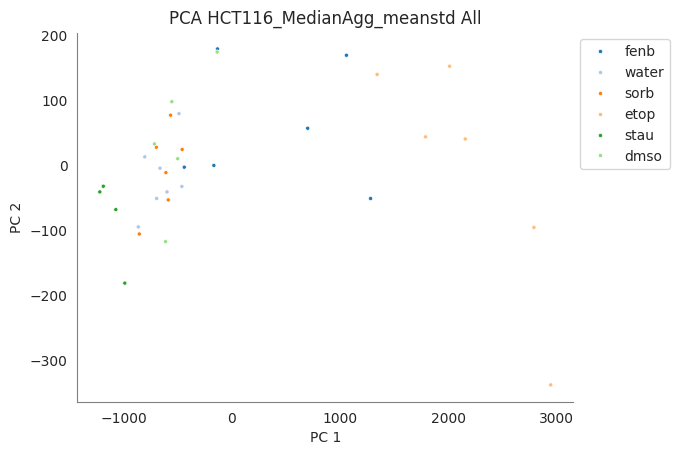

In [84]:
_ = makePCA(df5, name=filename)
# df2 = makeUMAP(df2, name=filename, is_supervised=False, use_pca=False)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


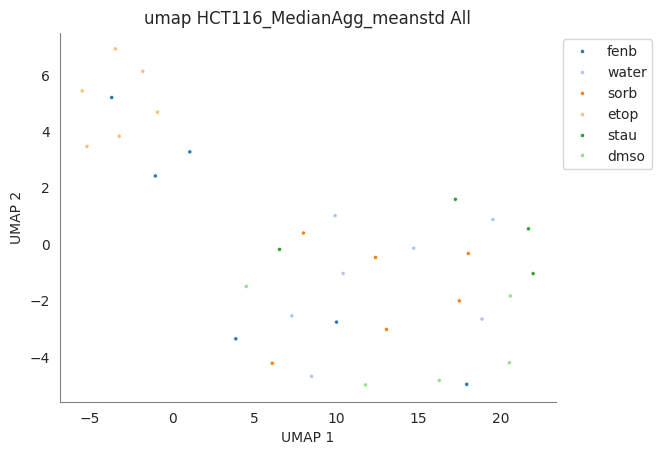

In [85]:
_ = makeUMAP(df5, name=filename, nn=100, is_supervised=False, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


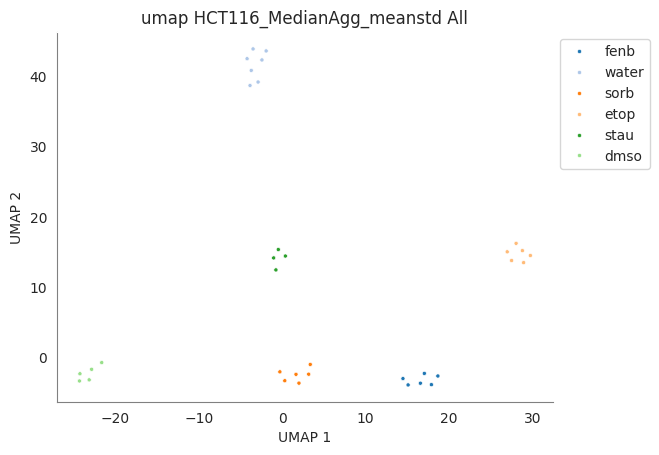

In [86]:
_ = makeUMAP(df5, name=filename, nn=100, is_supervised=True, use_pca=False)

### Here we transform only the screen

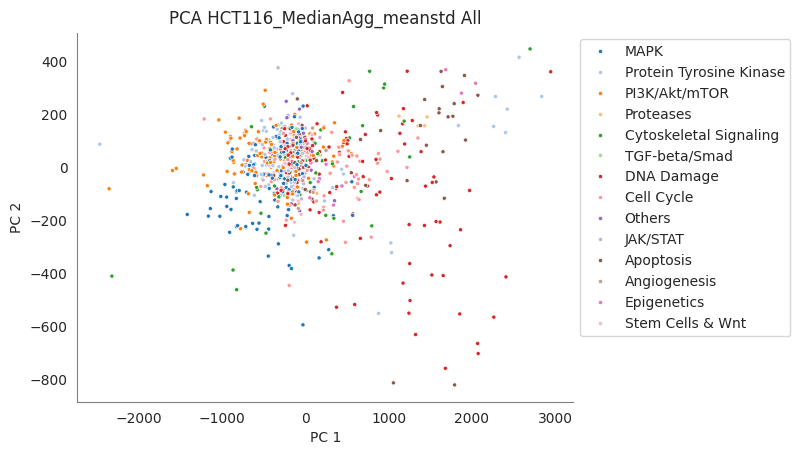

In [87]:
_ = makePCA(df3, name=filename)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


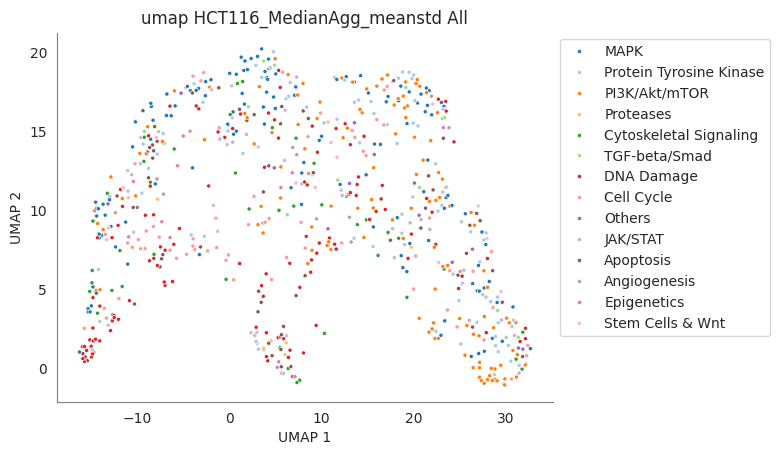

In [88]:
_ = makeUMAP(df3, name=filename, nn=100, is_supervised=False, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


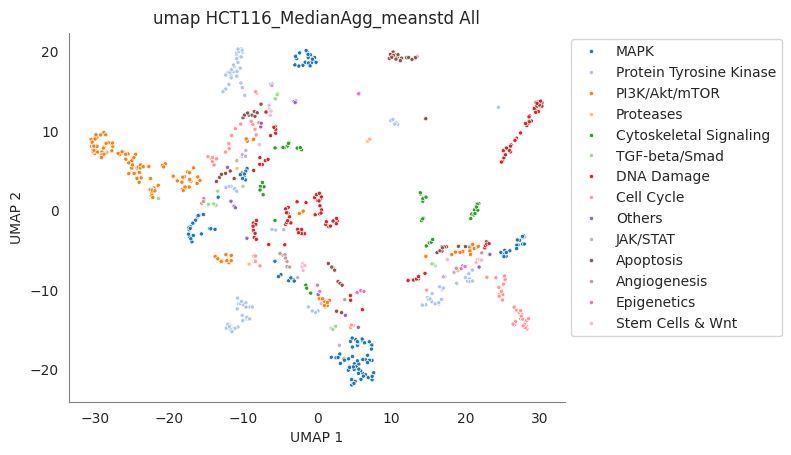

In [89]:
_ = makeUMAP(df3, name=filename,nn=100, is_supervised=True, use_pca=False)

### Here we run with active compounds and neg controls

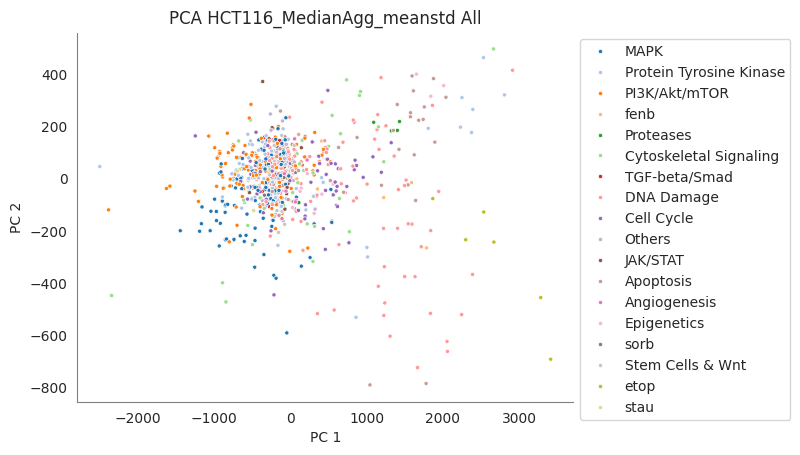

In [90]:
_ = makePCA(df4, name=filename)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


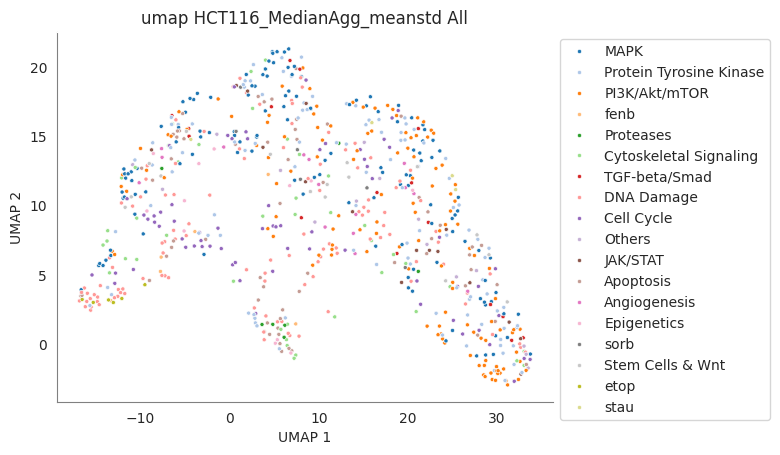

In [91]:
_ = makeUMAP(df4, name=filename, nn=100, is_supervised=False, use_pca=False)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


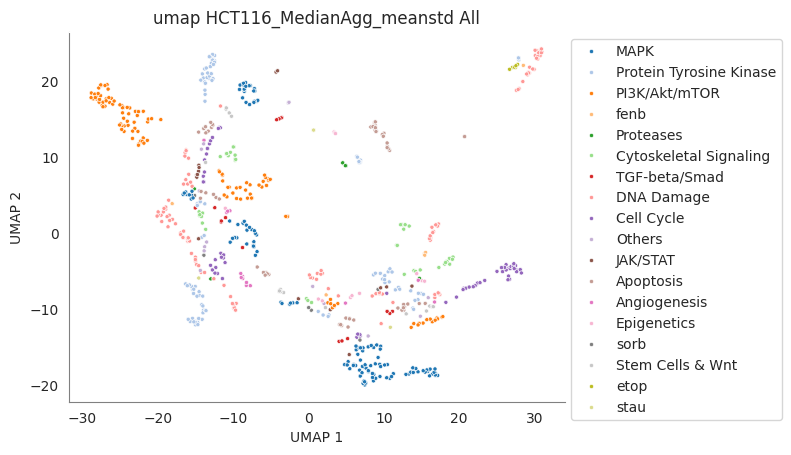

In [92]:
_ = makeUMAP(df4, name=filename,nn=100, is_supervised=True, use_pca=False)